# Projeto Udacity - Sistema de recomendações para usuários do MyAnimeList

In [94]:
from collections import defaultdict
import pandas as pd
import numpy as np
import scipy
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import surprise as sp

Referências e explicações:

Datasets utilizados: https://www.kaggle.com/azathoth42/myanimelist/version/9#_=_

Bíblia: https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101

Merges explicados: https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/

Gráficos explicados: http://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot

Análises de rating: https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

TO-DO:

Histograma de animes assistidos divido por gênero.

Tratar o gênero dos animes (talvez One-Hot-Encoder).

# Datasets

The datasets are mainly divided in three. One with info about the MyAnimeList customers (UsersDF) such as location, gender, birth date and so on. Another one for info about the anime, which brings data like the title of the show, what genre is it inside and even the opening themes. The last one (and also the biggest one) is all the scores that a certain user had with a show.

In [95]:
UsersDF = pd.read_csv('users_cleaned.csv')
AnimesDF = pd.read_csv('anime_cleaned.csv')
ScoresDF = pd.read_csv('animelists_cleaned.csv')

In [96]:
UsersDF.head()

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",1990-04-29 00:00:00,NaN,2013-03-03 00:00:00,2014-02-04 01:32:00,7.43,0.0,3391
1,Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",1991-08-01 00:00:00,NaN,2008-02-13 00:00:00,2017-07-10 06:52:54,6.15,6.0,4903
2,bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",1990-12-14 00:00:00,NaN,2009-08-31 00:00:00,2014-05-12 16:35:00,8.27,1.0,9701
3,terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",1998-08-24 00:00:00,NaN,2010-05-10 00:00:00,2012-10-18 19:06:00,9.70,6.0,697
4,Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",1999-10-24 00:00:00,NaN,2015-11-26 00:00:00,2018-05-10 20:53:37,7.86,0.0,1847


,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
3802,1535,Death Note,Death Note,デスノート,DN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,37,Finished Airing,...,Wednesdays at 00:56 (JST),"{'Adaptation': [{'mal_id': 21, 'type': 'manga'...","VAP, Konami, Ashi Production, Nippon Televisio...",Viz Media,Madhouse,"Mystery, Police, Psychological, Supernatural, ...","['#1: ""the WORLD"" by Nightmare (eps 1-19)', '#...","['#1: ""Alumina"" by Nightmare (eps 1-19)', '#2:...",23.0,2006.0


In [98]:
ScoresDF.head()

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-03 10:53:57,NaN
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,2013-03-27 15:59:13,NaN


In [99]:
#Since InteractionsDF is a huge DF (2GB of data) I`ll only take the columns that are important for the recommendation system
ScoresDF = ScoresDF[['username', 'anime_id', 'my_score', 'my_status']]

In [100]:
ScoresDFSampled = ScoresDF.sample(frac = 0.03, random_state = 42)
ScoresDFSampled.head()

,username,anime_id,my_score,my_status
28282899,Tijuana,889,10,2
19028665,firemon123,20159,0,2
19491144,Mihoshi,14833,9,2
15480301,OrangeAbundis,384,0,6
16428114,Kou_,15117,0,2


In [101]:
#Analysing all the possible values for the score
lower_rating = ScoresDFSampled['my_score'].min()
upper_rating = ScoresDFSampled['my_score'].max()
print('Range of ratings vary between: {0} to {1}'.format(lower_rating, upper_rating))

Range of ratings vary between: 0 to 10


In [102]:
#Only filtering animes in which people actually watched, are watching or are on hold as they are the most revelant for the rec sys
#RelevantScoresDF = ScoresDF[(ScoresDF['my_status'] == 1) | (ScoresDF['my_status'] == 2) | (ScoresDF['my_status'] == 3)]

In [111]:
#Counting how many relevant scores each user have done, resetting the index (so the series could become a DF again) and changing the column names
RatedsPerUser = ScoresDFSampled['username'].value_counts().reset_index().rename(columns={"username": "animes_rated", "index": "username"})

In [104]:
RatedsPerUser.head()

,username,animes_rated
0,Exxorn,206
1,DeadlyKizuna,205
2,uemmega,188
3,KanaenuYume,171
4,JakCooper2,168


In [125]:
#Grouping users whom had the same amount of animes rated
UserRatedsAggregated = RatedsPerUser['animes_rated'].value_counts().reset_index().rename(columns={"animes_rated": "group_size", "index": "animes_rated"}).sort_values(by=['animes_rated'])
UserRatedsAggregated.head(n = 30)

,animes_rated,group_size
0,1,10015
1,2,9060
2,3,8132
3,4,7413
4,5,6782
5,6,6000
6,7,5281
7,8,4720
8,9,4340
9,10,3771


In [112]:
#Counting how many relevant scores each anime has, resetting the index (so the series could become a DF again) and changing the column names
RatedsPerAnime = ScoresDFSampled['anime_id'].value_counts().reset_index().rename(columns={"anime_id": "number_of_users", "index": "anime_id"})
RatedsPerAnime.head()

,anime_id,number_of_users
0,1535,2452
1,1575,2054
2,20,1947
3,5114,1938
4,226,1926


In [116]:
#Grouping users whom had the same amount of animes rated
AnimeRatedsAggregated = RatedsPerAnime['number_of_users'].value_counts().reset_index().rename(columns={"number_of_users": "group_size", "index": "number_of_users"}).sort_values(by=['number_of_users'])
AnimeRatedsAggregated.head(n = 30)

,number_of_users,group_size
0,1,277
1,2,204
4,3,121
3,4,147
2,5,152
5,6,109
6,7,103
8,8,87
7,9,91
11,10,82


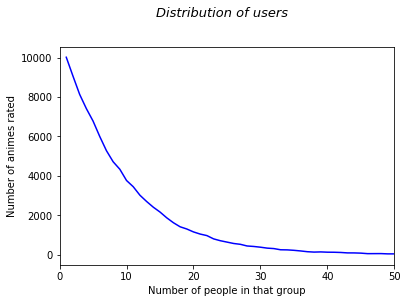

In [146]:
#As expected, most of our users have rated a lower amount of animes, but even so 
#I think we don't lose much information by excluding these customers for the user cold-start issue, so we will
#create an abirtrary cut line of only analysing users that have interacted with at least 10 animes

plt.suptitle("Distribution of users", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.plot('animes_rated', 'group_size', data = UserRatedsAggregated, color = 'blue')
plt.xlabel('Number of people in that group')
plt.ylabel('Number of animes rated')
plt.xlim(left = 0, right = 50)
plt.show()

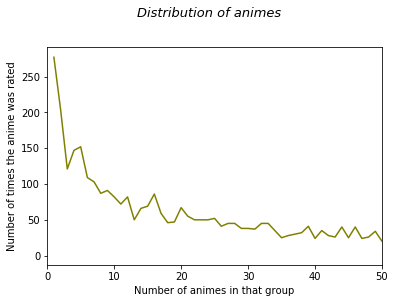

In [147]:
plt.suptitle("Distribution of animes", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.plot('number_of_users', 'group_size', data = AnimeRatedsAggregated, color = 'olive')
plt.xlabel('Number of animes in that group')
plt.ylabel('Number of times the anime was rated')
plt.xlim(left = 0, right = 50)
plt.show()

In [149]:
#Here we create another dataframe which contain only customers that have at least 10 valueable (as we filtered
#back then) ratings by merging our initial frame and the RatedsPerUser one. We also just bring the first three columns
#because it is already in the format of the library we will use

UserRatedsCutten = RatedsPerUser[RatedsPerUser['animes_rated'] >= 10]
AnimeRatedsCutten = RatedsPerAnime[RatedsPerAnime['number_of_users'] >= 20]
ScoresDFHotStart = pd.merge(ScoresDFSampled, UserRatedsCutten, left_on = 'username', right_on = 'username', how = 'inner')
ScoresDFHotStart = pd.merge(ScoresDFSampled, AnimeRatedsCutten, left_on = 'anime_id', right_on = 'anime_id', how = 'inner')
ScoresDFHotStart = ScoresDFHotStart[['username', 'anime_id', 'my_score']]

In [150]:
#Just for the record, lets analyse the pattern for the scores given by the site users

ScoresDF.count()

username     31283787
anime_id     31284030
my_score     31284030
my_status    31284030
dtype: int64

In [151]:
ScoresDFHotStart.count()

username    923920
anime_id    923930
my_score    923930
dtype: int64

In [152]:
ScoresDFHotStart.to_csv("Scores.csv")

In [153]:
ScoresDFHotStart[ScoresDFHotStart['username'] == '--AnimeBoy--']

,username,anime_id,my_score
167872,--AnimeBoy--,7058,6
479876,--AnimeBoy--,9289,0
568500,--AnimeBoy--,2476,6
577918,--AnimeBoy--,12113,0
609801,--AnimeBoy--,4192,8
665569,--AnimeBoy--,10711,6
680115,--AnimeBoy--,8101,0
778830,--AnimeBoy--,14353,0
817411,--AnimeBoy--,16169,5
850734,--AnimeBoy--,12695,5


In [154]:
'''reader = sp.Reader(rating_scale=(0, 10))
data = sp.Dataset.load_from_df(ScoresDFHotStart[['username', 'anime_id', 'my_score']], reader)
trainset = data.build_full_trainset()
algo = sp.SVD()
algo.fit(trainset)
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
last_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
last_predictions['Iu'] = last_predictions.uid.apply(get_Iu)
last_predictions['Ui'] = last_predictions.iid.apply(get_Ui)
last_predictions['err'] = abs(last_predictions.est - last_predictions.rui)
#sp.accuracy.rmse(predictions)'''

KeyboardInterrupt: 

In [76]:
#last_predictions = last_predictions.sort_values(by=['uid', 'err'])

In [77]:
#last_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
7362566,--kitade--,8986,5.152717,5.155302,{'was_impossible': False},17,4,0.002585
7362998,--kitade--,2403,5.152717,5.155572,{'was_impossible': False},17,18,0.002855
7363264,--kitade--,36106,5.152717,5.161486,{'was_impossible': False},17,4,0.008770
7358969,--kitade--,25537,5.152717,5.165316,{'was_impossible': False},17,11,0.012599
7359124,--kitade--,2369,5.152717,5.137311,{'was_impossible': False},17,16,0.015405
